In [2]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from lib.obs import asos_raw, hourly_precip
from events_calc import precip_events

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
stations = ['SAC', 'RNO']
time_periods = [
    ('1980-07-01', '1990-06-30'),
    ('1990-07-01', '2000-06-30'),
    ('2000-07-01', '2010-06-30'),
    ('2010-07-01', '2020-06-30')
]

In [4]:
dfs = []
max_cluster = 0
for time_period in time_periods:
    precip = hourly_precip(stations, *time_period)
    precip_clusts = precip_events(precip, eps=6, min_samples=12)
    outliers = precip_clusts < 0
    
    precip_clusts += max_cluster
    max_cluster += precip_clusts.max()+1
    precip['clust'] = precip_clusts
    batch_rain_events = precip[~outliers]
    dfs.append(batch_rain_events)
    
rain_events = pd.concat(dfs)

In [5]:
events_agg = rain_events.groupby(['station', 'clust'], as_index=False).agg({
    'precip_in': sum,
    'valid': [min, max],
})

events_agg.columns.droplevel(level=0)
events_agg.columns = ['station', 'clust', 'precip_in', 'min_time', 'max_time'] 

In [6]:
sfos = events_agg[events_agg.station == 'SAC']
renos = events_agg[events_agg.station == 'RNO']
combined = sfos.merge(renos, on='clust', how='inner', suffixes=['_sac', '_reno'])

In [7]:
combined

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno
0,SAC,0,0.35,1980-07-02 09:00:00,1980-07-03 01:00:00,RNO,0.44,1980-07-02 11:00:00,1980-07-03 03:00:00
1,SAC,4,1.30,1980-12-03 02:00:00,1980-12-04 09:00:00,RNO,0.60,1980-12-04 01:00:00,1980-12-04 14:00:00
2,SAC,5,2.76,1981-01-26 13:00:00,1981-01-29 09:00:00,RNO,0.74,1981-01-27 06:00:00,1981-01-29 13:00:00
3,SAC,6,0.08,1981-02-09 01:00:00,1981-02-09 08:00:00,RNO,0.15,1981-02-09 00:00:00,1981-02-09 14:00:00
4,SAC,7,0.24,1981-02-13 13:00:00,1981-02-13 19:00:00,RNO,0.01,1981-02-13 21:00:00,1981-02-13 21:00:00
...,...,...,...,...,...,...,...,...,...
700,SAC,2490,0.25,2019-12-29 23:00:00,2019-12-30 03:00:00,RNO,0.02,2019-12-30 03:00:00,2019-12-30 04:00:00
701,SAC,2491,0.32,2020-01-16 16:00:00,2020-01-16 22:00:00,RNO,0.10,2020-01-16 21:00:00,2020-01-16 22:00:00
702,SAC,2492,0.26,2020-01-26 05:00:00,2020-01-26 14:00:00,RNO,0.01,2020-01-26 09:00:00,2020-01-26 09:00:00
703,SAC,2494,0.24,2020-03-15 07:00:00,2020-03-15 17:00:00,RNO,0.03,2020-03-15 09:00:00,2020-03-15 13:00:00


(0.0, 3.0)

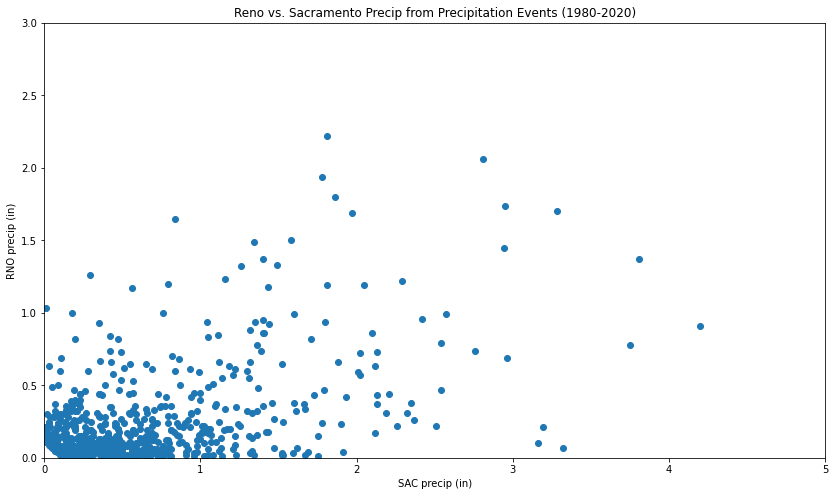

In [8]:
plt.figure(figsize=(14, 8))
plt.scatter(x=combined.precip_in_sac, y=combined.precip_in_reno)
plt.title('Reno vs. Sacramento Precip from Precipitation Events (1980-2020)')
plt.xlabel('SAC precip (in)')
plt.xlim([0, 5])
plt.ylabel('RNO precip (in)')
plt.ylim([0, 3])

In [9]:
threshold = combined.precip_in_sac.mean() + 1.5 * combined.precip_in_sac.std()
threshold

1.6640783279156948

In [10]:
big_events = combined[
    (combined.precip_in_sac > threshold) & 
    (combined.min_time_sac.dt.month.isin([11, 12, 1, 2, 3])) &
    (combined.precip_in_sac < 5)
]
big_events['rno_sac_ratio'] = big_events.precip_in_reno / big_events.precip_in_sac
big_events.shape

<ipython-input-10-beab88bc7015>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_events['rno_sac_ratio'] = big_events.precip_in_reno / big_events.precip_in_sac


(47, 10)

In [11]:
strong_shadow = big_events.sort_values(by='rno_sac_ratio').head(12) 
weak_shadow = big_events.sort_values(by='rno_sac_ratio').tail(12)

In [12]:
strong_shadow

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno,rno_sac_ratio
244,SAC,399,1.67,1993-02-08 01:00:00,1993-02-09 08:00:00,RNO,0.02,1993-02-08 13:00:00,1993-02-09 01:00:00,0.011976
114,SAC,146,1.91,1985-11-24 08:00:00,1985-11-25 12:00:00,RNO,0.04,1985-11-24 16:00:00,1985-11-25 05:00:00,0.020942
658,SAC,2442,3.32,2018-01-08 11:00:00,2018-01-09 14:00:00,RNO,0.07,2018-01-09 02:00:00,2018-01-09 13:00:00,0.021084
503,SAC,1190,1.69,2010-01-19 12:00:00,2010-01-21 09:00:00,RNO,0.04,2010-01-20 21:00:00,2010-01-21 03:00:00,0.023669
688,SAC,2474,3.16,2019-02-25 20:00:00,2019-02-28 02:00:00,RNO,0.10,2019-02-27 11:00:00,2019-02-27 12:00:00,0.031646
239,SAC,394,3.19,1993-01-12 21:00:00,1993-01-14 12:00:00,RNO,0.21,1993-01-13 00:00:00,1993-01-14 14:00:00,0.065831
467,SAC,1145,2.12,2008-01-21 18:00:00,2008-01-24 11:00:00,RNO,0.17,2008-01-21 18:00:00,2008-01-24 11:00:00,0.080189
284,SAC,537,1.75,1999-02-06 17:00:00,1999-02-07 18:00:00,RNO,0.15,1999-02-07 13:00:00,1999-02-07 20:00:00,0.085714
93,SAC,113,2.51,1983-12-24 11:00:00,1983-12-25 22:00:00,RNO,0.22,1983-12-24 07:00:00,1983-12-26 00:00:00,0.087649
68,SAC,81,2.26,1983-03-12 09:00:00,1983-03-13 21:00:00,RNO,0.22,1983-03-13 10:00:00,1983-03-13 17:00:00,0.097345


In [16]:
strong_shadow[['min_time_sac', 'min_time_reno']].apply(np.mean, axis=1)

244   1993-02-08 07:00:00
114   1985-11-24 12:00:00
658   2018-01-08 18:30:00
503   2010-01-20 04:30:00
688   2019-02-26 15:30:00
239   1993-01-12 22:30:00
467   2008-01-21 18:00:00
284   1999-02-07 03:00:00
93    1983-12-24 09:00:00
68    1983-03-12 21:30:00
577   2014-02-08 06:00:00
539   2011-03-14 04:00:00
dtype: datetime64[ns]

In [14]:
weak_shadow

,station_sac,clust,precip_in_sac,min_time_sac,max_time_sac,station_reno,precip_in_reno,min_time_reno,max_time_reno,rno_sac_ratio
20,SAC,26,1.71,1981-12-18 14:00:00,1981-12-20 17:00:00,RNO,0.82,1981-12-19 11:00:00,1981-12-20 17:00:00,0.479532
631,SAC,2411,3.28,2017-01-07 09:00:00,2017-01-09 09:00:00,RNO,1.70,2017-01-07 16:00:00,2017-01-09 12:00:00,0.518293
460,SAC,1138,1.80,2007-12-06 16:00:00,2007-12-07 13:00:00,RNO,0.94,2007-12-06 21:00:00,2007-12-07 17:00:00,0.522222
632,SAC,2412,2.29,2017-01-10 01:00:00,2017-01-11 15:00:00,RNO,1.22,2017-01-10 03:00:00,2017-01-11 10:00:00,0.532751
384,SAC,1046,2.05,2004-02-25 11:00:00,2004-02-26 19:00:00,RNO,1.19,2004-02-25 16:00:00,2004-02-26 13:00:00,0.580488
423,SAC,1093,2.95,2005-12-30 22:00:00,2005-12-31 17:00:00,RNO,1.74,2005-12-30 18:00:00,2005-12-31 22:00:00,0.589831
336,SAC,990,1.81,2001-12-01 06:00:00,2001-12-03 11:00:00,RNO,1.19,2001-12-02 10:00:00,2001-12-03 05:00:00,0.657459
686,SAC,2472,2.81,2019-02-13 07:00:00,2019-02-15 21:00:00,RNO,2.06,2019-02-13 14:00:00,2019-02-15 22:00:00,0.733096
354,SAC,1014,1.97,2002-12-14 21:00:00,2002-12-16 16:00:00,RNO,1.69,2002-12-15 00:00:00,2002-12-17 02:00:00,0.857868
193,SAC,249,1.86,1990-02-16 04:00:00,1990-02-17 00:00:00,RNO,1.80,1990-02-16 09:00:00,1990-02-16 23:00:00,0.967742


In [17]:
weak_shadow[['min_time_sac', 'min_time_reno']].apply(np.mean, axis=1)

20    1981-12-19 00:30:00
631   2017-01-07 12:30:00
460   2007-12-06 18:30:00
632   2017-01-10 02:00:00
384   2004-02-25 13:30:00
423   2005-12-30 20:00:00
336   2001-12-01 20:00:00
686   2019-02-13 10:30:00
354   2002-12-14 22:30:00
193   1990-02-16 06:30:00
464   2008-01-04 10:30:00
644   2017-02-20 10:00:00
dtype: datetime64[ns]